In [35]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import CSVLogger

from keras import backend as K
from keras.initializers import RandomUniform, RandomNormal

from PIL import Image

from tqdm import tqdm
from datetime import datetime

%matplotlib inline

In [2]:
# resolution of images

h = 75
w = 100

In [3]:
#Creates list of positiv files
positiv_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/pos/IMG_*.png')
#Finds the number of positiv files
positiv_len = len(positiv_list)
print("Size of positiv Sample: {}".format(positiv_len))

#Same but for negativ files
negativ_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/neg/IMG_*.png')
negativ_len = len(negativ_list)
print("Size of negativ Sample: {}".format(negativ_len))

Size of positiv Sample: 8590
Size of negativ Sample: 13846


In [5]:
X_posind = []
X_negind = []
X_posinu = []
X_neginu = []
X_posinl = []
X_neginl = []
X_posinr = []
X_neginr = []

X_pos = []
X_neg = []

for fname in tqdm(positiv_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_posind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_posinu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_posinr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_posinl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_pos.append(img) 
    
# Random picking of neg images with the given ratio to the pos images
ratio_pos_neg = 1
    
for fname in tqdm(np.random.choice(negativ_list, replace=False, size=int(len(X_pos) / ratio_pos_neg))):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_negind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_neginu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_neginr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_neginl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_neg.append(img)

100%|██████████| 8590/8590 [00:50<00:00, 168.87it/s]


In [6]:
X_posind = np.array(X_posind)
X_negind = np.array(X_negind)
X_posinu = np.array(X_posinu)
X_neginu = np.array(X_neginu)
X_posinl = np.array(X_posinl)
X_neginl = np.array(X_neginl)
X_posinr = np.array(X_posinr)
X_neginr = np.array(X_neginr)
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)

In [7]:
X_all = np.concatenate((X_pos, X_neg), axis=0)
Y_all = np.concatenate( ( np.ones(len(X_pos)), np.zeros(len(X_neg)) ) , axis=0)
#X_all_trans = np.concatenate((X_pos, X_posind, X_posinu, X_posinl, X_posinr, X_neg, X_negind, X_neginu, X_neginl, X_neginr), axis=0)
#Y_all_trans = np_utils.to_categorical(np.concatenate((np.ones((5*positiv_len, 1)), np.zeros((5*negativ_len,1))), axis=0), 2)

In [9]:
X_all.shape

(17180, 75, 100)

In [10]:
Y_all.shape

(17180,)

In [11]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all = X_all[randomize]
Y_all = Y_all[randomize]

In [12]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_all[:200]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_all[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [13]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all))

# Separate in Training and Testing Sample
X_train = X_all[train_split:]
Y_train = Y_all[train_split:]

X_test = X_all[:train_split]
Y_test = Y_all[:train_split]

In [14]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_test[:100]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_test[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [15]:
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16321, 75, 100, 1)
(16321,)
(859, 75, 100, 1)
(859,)


### Test with lower resolution

In [64]:
x_new = 30
y_new = 40

In [65]:
X_all_30_40 = []
for img in X_all:
    X_all_30_40.append(scipy.misc.imresize(np.array(img),(x_new,y_new)))
    
X_all_30_40 = np.array(X_all_30_40)
Y_all_30_40 = Y_all

In [ ]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all_30_40 = X_all_30_40[randomize]
Y_all_30_40 = Y_all_30_40[randomize]

In [ ]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all_30_40))

# Separate in Training and Testing Sample
X_train_30_40 = X_all_30_40[train_split:]
Y_train_30_40 = Y_all_30_40[train_split:]

X_test_30_40 = X_all_30_40[:train_split]
Y_test_30_40 = Y_all_30_40[:train_split]

In [ ]:
X_train_30_40 = X_train_30_40.reshape(X_train_30_40.shape[0], x_new, y_new, 1)
X_test_30_40 = X_test_30_40.reshape(X_test_30_40.shape[0], x_new, y_new, 1)

# Data need to be normalised
* Mean and StdDev for each pixel over whole data set

In [16]:
X_train.shape

(16321, 75, 100, 1)

In [17]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

#means_30_40 = np.mean(X_train_30_40, axis=0)
#stds_30_40 = np.std(X_train_30_40, axis=0)

In [18]:
print(means.shape)
print(stds.shape)
#print(means_30_40.shape)
#print(stds_30_40.shape)

(75, 100, 1)
(75, 100, 1)


In [19]:
path_meanstd = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/MeansStdDev/'

if not os.path.exists(path_meanstd):
    os.makedirs(path_meanstd)
    print('Created path: {}'.format(path_meanstd))
                                            
#np.savetxt('../Data/Means_30_40.txt', means_30_40)
#np.savetxt('../Data/StdDev_30_40.txt', stds_30_40)
np.savetxt(path_meanstd +'Means_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', means)
np.savetxt(path_meanstd +'StdDev_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', stds)

Created path: ../TrainedModels/2017-09-10/MeansStdDev/


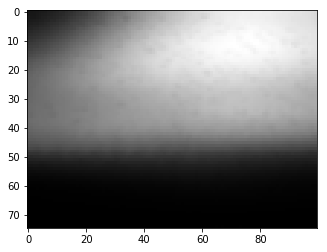

In [20]:
plt.imshow(np.squeeze(means), cmap='gray')
plt.savefig(path_meanstd + 'MeanImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

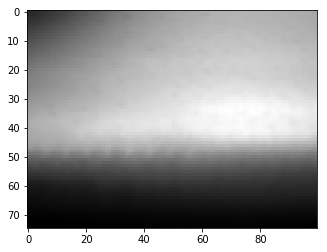

In [21]:
plt.imshow(np.squeeze(stds), cmap='gray')
plt.savefig(path_meanstd + 'StdImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

In [22]:
X_train_norm = np.array([(img-means)/stds for img in X_train])
X_test_norm = np.array([(img-means)/stds for img in X_test])

In [ ]:
#X_train_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_train_30_40])
#X_test_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_test_30_40])

# Let the training begin...

In [23]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [24]:
input_shape= (h,w,1)
#input_shape_30_40= (x_new,y_new,1)

* initializer need to have mean = 0 and std 1/input_shape
* for successive layers output shape of previous layer will declare this

In [25]:
path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

if not os.path.exists(path_model):
    os.makedirs(path_model)
    print('Created path: {}'.format(path_model))

In [101]:
model = Sequential()

# First Convolutional layer initialised with random input weights
model.add(Conv2D(16, (7,7), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))
mult_shape1 = np.prod(model.layers[1].output_shape[1:])

# Second Convolutional layer
model.add(Conv2D(16, (5,5), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))
mult_shape2 = np.prod(model.layers[3].output_shape[1:])

# Third Convolutional layer
model.add(Conv2D(16, (3,3), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2), padding='valid', activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))

#Converting the 2D images to 1D vectors
model.add(Flatten())  
mult_shape3 = np.prod(model.layers[6].output_shape[1:])

# First Fully connected layer
model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
model.add(Dropout(0.2))
mult_shape4 = np.prod(model.layers[8].output_shape[1:])

#Second Fully connected layer
model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))
model.add(Dropout(0.2))
mult_shape5 = np.prod(model.layers[10].output_shape[1:])

#Output layer
model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape5)))

In [102]:
model.summary()

# Open the file
with open('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/ModelSummary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 69, 94, 16)        800       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 47, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 43, 16)        6416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 21, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 19, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 9, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 864)               0         
__________

In [62]:
#Defining optimiser and compiling the model

model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history = LossHistory()

In [31]:
# if you want to continue a training
if False:
    model = load_model('../TrainedModels/2017-09-09/169_167_200_200_selu_100epochs.h5')

In [63]:
model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

#Evaluating trained model on test images
score = model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Train on 15504 samples, validate on 817 samples
Epoch 1/100
15504/15504 [==============================] - 51s - loss: 0.5941 - acc: 0.6716 - val_loss: 0.4684 - val_acc: 0.7528
Epoch 2/100
15504/15504 [==============================] - 53s - loss: 0.4389 - acc: 0.7873 - val_loss: 0.3275 - val_acc: 0.8360
Epoch 3/100
15504/15504 [==============================] - 54s - loss: 0.2903 - acc: 0.8723 - val_loss: 0.1972 - val_acc: 0.9339
Epoch 4/100
15504/15504 [==============================] - 54s - loss: 0.1305 - acc: 0.9491 - val_loss: 0.1376 - val_acc: 0.9425
Epoch 5/100
15504/15504 [==============================] - 52s - loss: 0.0804 - acc: 0.9703 - val_loss: 0.0727 - val_acc: 0.9743
Epoch 6/100
15504/15504 [==============================] - 52s - loss: 0.0582 - acc: 0.9784 - val_loss: 0.0542 - val_acc: 0.9804
Epoch 7/100
15504/15504 [==============================] - 52s - loss: 0.0490 - acc: 0.9816 - val_loss: 0.0627 - val_acc: 0.9780
Epoch 8/100
15504/15504 [========================

15504/15504 [==============================] - 52s - loss: 0.0181 - acc: 0.9956 - val_loss: 0.0282 - val_acc: 0.9951
Epoch 64/100
15504/15504 [==============================] - 52s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0190 - val_acc: 0.9976
Epoch 65/100
15504/15504 [==============================] - 52s - loss: 8.1807e-04 - acc: 0.9997 - val_loss: 0.0218 - val_acc: 0.9976
Epoch 66/100
15504/15504 [==============================] - 52s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0099 - val_acc: 0.9963
Epoch 67/100
15504/15504 [==============================] - 52s - loss: 0.0045 - acc: 0.9990 - val_loss: 0.0182 - val_acc: 0.9927
Epoch 68/100
15504/15504 [==============================] - 52s - loss: 0.0053 - acc: 0.9987 - val_loss: 0.0073 - val_acc: 0.9963
Epoch 69/100
15504/15504 [==============================] - 52s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0219 - val_acc: 0.9963
Epoch 70/100
15504/15504 [==============================] - 52s - loss: 0.0067 - acc: 0.9981 - val_

In [64]:
#To save trained NN - USE DIFFERENT NAME FOR NEW NETWORK
model.save(path_model + '167_165_163_200_200_selu_100epochs.h5')

In [65]:
np.savetxt(path_model + '167_165_163_200_200_selu_100epochs_TrainingData.txt', np.transpose([history.accuracy, history.losses]))

### Accuracy and Losss during training

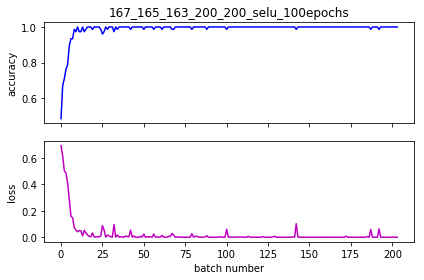

In [85]:
accuracy = np.array(history.accuracy)
losses = np.array(history.losses)

fig, ax = plt.subplots(2, sharex=True)

every_item = 100

ax[0].plot(accuracy[::every_item], color = 'b', marker='', ls='-')
ax[1].plot(losses[::every_item], color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')

#ax[1].set_yscale('log')

ax[0].set_title('167_165_163_200_200_selu_100epochs')

plt.tight_layout()
plt.savefig('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/LossAcc::{}.png'.format(every_item))

### Score Distributions

In [86]:
# Get probs per image
probs = []

i=0 
for img in X_test_norm:
    #plt.imshow(np.squeeze(img), cmap='gray')
    
    img = np.reshape(img, [1,h,w,1])
    p = model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
    #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
    #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
    #plt.savefig('../Plots/TestImg/{}.png'.format(i))
    i+=1

probs = np.array(probs)

In [95]:
np.savetxt('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/ScoresOnTestData.txt', np.transpose([Y_test, probs]))

In [87]:
label_pos = Y_test
score_pos = probs[label_pos == 1]
score_neg = probs[label_pos == 0]

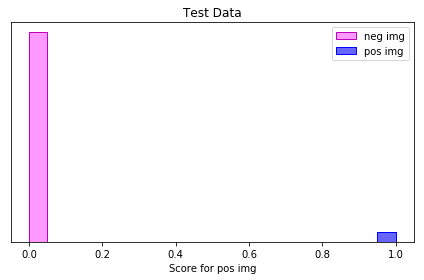

In [94]:
fig, ax = plt.subplots()

binsize = 0.05
bins = np.arange(0, 1 + binsize, binsize)

ax.hist(score_neg, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', label='neg img')
ax.hist(score_pos, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', label='pos img')

ax.hist(score_neg, bins=bins, histtype='step', linewidth=1, linestyle='-', edgecolor='m')
ax.hist(score_pos, bins=bins, histtype='step', linewidth=1, linestyle='-',edgecolor='b')

ax.set_xlabel("Score for pos img")
ax.set_yscale('log')

ax.legend(loc='best')

plt.title('Test Data')

plt.tight_layout()
plt.savefig('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/ScoreDistributionOnTestData_{}.png'.format(binsize))

In [91]:
# positive images below 0.5
img_pos = X_test_norm[label_pos == 1]
img_pos_false = img_pos[score_pos < 0.5]
score_pos_false = score_pos[score_pos < 0.5]
print(img_pos_false.shape)

# negative images over 0.5
img_neg = X_test_norm[label_pos == 0]
img_neg_false = img_neg[score_neg > 0.5]
score_neg_false = score_neg[score_neg > 0.5]
print(img_neg_false.shape)

(0, 75, 100, 1)
(0, 75, 100, 1)


In [92]:
## wrongly classified pics:

for i, (pic,p) in enumerate(zip(img_pos_false[:], score_pos_false[:])):
    plt.imshow(np.squeeze(pic), cmap='gray')
    
    plt.title('Score: {:}'.format(p))
    #plt.savefig('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/wrongImg/pos_{}.png'.format(i))
    plt.show()

In [93]:
## wrongly classified pics:

for i, (pic,p) in enumerate(zip(img_neg_false[:], score_neg_false[:])):
    plt.imshow(np.squeeze(pic), cmap='gray')
    
    plt.title('Score: {:}'.format(p))
    #plt.savefig('../Data/2017-09-10/167_165_163_200_200_selu_100epochs/wrongImg/neg_{}.png'.format(i))
    plt.show()